# Load metadata

This assumes that the file train.zip has been unzipped in the current directory.  If needed, insert code here to load the data from your computer.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

!unzip "/content/drive/My Drive/Colab Notebooks/train.zip"
!ls

Output hidden; open in https://colab.research.google.com to view.

In [0]:
import json
import numpy as np


# load metadata
with open("train.json", 'r') as f:
    metadata = json.load(f)
n_claims = len(metadata)

# Preprocess articles

This code preprocesses the aticles to extract the top 5 sentences with greatest similarity to the claim according to tf-idf.

In [0]:
def preprocess_articles():

    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt')
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)

    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):
  
        if id % 500 == 0:
            print("Claims preprocessed: ",id)
        
        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            filename = "train_articles/" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'r') as text_file:
                text = text_file.read()
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)
    
        # measure similarity between claim and each sentence
        similarity =  X[-1,:] @ np.transpose(X[:-2,:])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1,min(5,sorted_index.shape[1])+1):
            top_sentences.append(sentences[sorted_index[0,-i]])
        relevant_sentences.append(top_sentences)

   
    return metadata, relevant_sentences

metadata, relevant_sentences = preprocess_articles()
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Claims preprocessed:  0
Claims preprocessed:  500
Claims preprocessed:  1000
Claims preprocessed:  1500
Claims preprocessed:  2000
Claims preprocessed:  2500
Claims preprocessed:  3000
Claims preprocessed:  3500
Claims preprocessed:  4000
Claims preprocessed:  4500
Claims preprocessed:  5000
Claims preprocessed:  5500
Claims preprocessed:  6000
Claims preprocessed:  6500
Claims preprocessed:  7000
Claims preprocessed:  7500
Claims preprocessed:  8000
Claims preprocessed:  8500
Claims preprocessed:  9000
Claims preprocessed:  9500
Claims preprocessed:  10000
Claims preprocessed:  10500
Claims preprocessed:  11000
Claims preprocessed:  11500
Claims preprocessed:  12000
Claims preprocessed:  12500
Claims preprocessed:  13000
Claims preprocessed:  13500
Claims preprocessed:  14000
Claims preprocessed:  14500
Claims preprocessed:  15000
Claims preprocessed:  15500
Metadata of claim 0:
A

In [0]:
import json

with open("/content/drive/My Drive/Colab Notebooks/relevant_sentenses.json", 'w') as f:
    json.dump(relevant_sentences, f)

In [0]:
import json

with open('/content/drive/My Drive/Colab Notebooks/relevant_sentenses.json') as f:
    relevant_sentences = json.loads(f)

# Sample a claim
Sample a claim, tokenize it and embed it.

In [0]:
!pip install bpemb

     |████████████████████████████████| 1.0MB 10.4MB/s 


In [0]:
from bpemb import BPEmb
n_embedding_dims = 50
bpemb_en = BPEmb(lang="en", dim=n_embedding_dims)

def sampleClaim(metadata, sampleType=1): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"]
    claimant = metadata[id]["claimant"]
    if sampleType == 2 or sampleType == 3:
      claim = claim + '\n'+ claimant
    if sampleType == 3:
      sentences = '\n'.join(relevant_sentences[id])
      claim = claim + '\n' + sentences
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id



downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.model


100%|██████████| 1924908/1924908 [00:00<00:00, 22109047.53B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.d50.w2v.bin.tar.gz


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Architecture
=======

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import random

class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        return self.embed(x)


class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** (i / d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** (i / d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False) # .cuda()
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v):
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
# calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, None, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output

def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output


# The feed-forward layer simply deepens our network, employing linear layers to analyse patterns in the attention layers output.
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x


class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm


# build an encoder layer with one multi-head attention layer and one # feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
  
# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        # self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, src):
        # x = self.embed(src)
        x = self.pe(src)
        for i in range(N):
            x = self.layers[i](x)
        return self.norm(x)

class Classifier(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden):
        hidden = torch.mean(hidden, dim=-3)
        hidden = self.h2o(hidden) # first take mean or first map to output size
        output = self.softmax(hidden)
        return output


class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.classifier = Classifier(d_model, trg_vocab)
        # self.out = nn.Linear(trg_vocab, trg_vocab)
    def forward(self, src):
        e_outputs = self.encoder(src)
        d_output = self.classifier(e_outputs)
        # output = self.out(d_output)
        return d_output
#  softmax will be handled automatically by our loss function

Training Procedure of Transformer
=====

In [0]:
import math
import copy
import time

d_model = n_embedding_dims# 512 # 128
n_categories = 3

heads = 10 # 8
N = 5 #6
src_vocab = n_embedding_dims
trg_vocab = n_categories



def train_model(epochs, sampleType, print_every=1000):
    criterion = nn.NLLLoss()
    model = Transformer(src_vocab, trg_vocab, d_model, N, heads)
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    # this code is very important! It initialises the parameters with a
    # range of values that stops the signal fading or getting too big..
    optim = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
    
    model.train()
    
    start = time.time()
    temp = start
    
    total_loss = 0
    train_data = metadata[:10000]
    test_data = metadata[10000:]
    average_train_accuracy = 0
    average_test_accuracy = 0
    all_train_accuracies = []
    all_test_accuracies = []
    count = 0
    for epoch in range(epochs):
    # for i, batch in enumerate(train_iter):
            train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaim(train_data, sampleType)
            train_src = train_line_tensor
            train_trg = train_category_tensor
            # train
            optim.zero_grad()
            train_output = model(train_src)
            # train_loss = F.cross_entropy(train_output, train_trg)
            train_loss = criterion(train_output, train_trg) # output dim
            train_loss.backward()
            #print(train_output[0])
            #print(train_trg)
            #print(train_loss)
            optim.step()
            
            top_train_value, top_train_index = train_output.topk(1)
            train_guess_category = top_train_index[0].item()
            train_accuracy = 1 if train_guess_category == train_category else 0
            average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
            

            test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaim(test_data, sampleType)
            test_src = test_line_tensor
            test_trg = test_category_tensor
            optim.zero_grad()
            test_output = model(test_src)
            
            top_test_value, top_test_index = test_output.topk(1)
            test_guess_category = top_test_index[0].item()
            test_accuracy = 1 if test_guess_category == test_category else 0
            average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)

            count += 1                   
            total_loss += train_loss.item() #.data[0]

            if (epoch + 1) % print_every == 0:
                train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
                test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category

                loss_avg = total_loss / print_every
                print("time = %dm, epoch %d, loss = %.3f, %ds per %d iters" % ((time.time() - start) // 60,
                epoch + 1, loss_avg, time.time() - temp, print_every))
                print('Train:  average_accuracy=%.4f %s  Test:  average_accuracy=%.4f %s' % (average_train_accuracy, train_correct, average_test_accuracy, test_correct))   
                all_train_accuracies.append(average_train_accuracy)
                all_test_accuracies.append(average_test_accuracy)
                average_train_accuracy = 0
                average_test_accuracy = 0
                total_loss = 0
                count = 0
                temp = time.time()
    return  all_train_accuracies, all_test_accuracies 


# Train and Plot results





In [0]:
epochs = 100000
all_train_accuracies_i, all_test_accuracies_i = train_model(epochs, 1)

time = 0m, epoch 1000, loss = 1.015, 48s per 1000 iters
Train:  average_accuracy=0.4860 ✓  Test:  average_accuracy=0.4980 ✓
time = 1m, epoch 2000, loss = 0.956, 47s per 1000 iters
Train:  average_accuracy=0.5270 ✓  Test:  average_accuracy=0.5610 ✗ (2)
time = 2m, epoch 3000, loss = 0.923, 48s per 1000 iters
Train:  average_accuracy=0.5560 ✓  Test:  average_accuracy=0.5140 ✓
time = 3m, epoch 4000, loss = 0.931, 47s per 1000 iters
Train:  average_accuracy=0.5250 ✗ (0)  Test:  average_accuracy=0.5270 ✗ (1)
time = 3m, epoch 5000, loss = 0.953, 47s per 1000 iters
Train:  average_accuracy=0.5310 ✗ (2)  Test:  average_accuracy=0.5640 ✗ (1)
time = 4m, epoch 6000, loss = 0.910, 46s per 1000 iters
Train:  average_accuracy=0.5590 ✓  Test:  average_accuracy=0.5360 ✓
time = 5m, epoch 7000, loss = 0.927, 46s per 1000 iters
Train:  average_accuracy=0.5490 ✓  Test:  average_accuracy=0.5740 ✓
time = 6m, epoch 8000, loss = 0.922, 46s per 1000 iters
Train:  average_accuracy=0.5490 ✗ (2)  Test:  average_ac

In [0]:
print(all_train_accuracies_i)
print(all_test_accuracies_i)

[0.48599999999999993, 0.527, 0.5560000000000007, 0.5249999999999997, 0.5309999999999994, 0.5590000000000012, 0.5490000000000006, 0.5490000000000016, 0.5519999999999998, 0.5759999999999995, 0.566000000000001, 0.5639999999999991, 0.5769999999999995, 0.5679999999999995, 0.5769999999999993, 0.5919999999999997, 0.5520000000000003, 0.5930000000000005, 0.572000000000001, 0.5930000000000009, 0.5920000000000006, 0.5990000000000002, 0.5699999999999997, 0.5859999999999986, 0.615, 0.6019999999999991, 0.5959999999999999, 0.5840000000000005, 0.584, 0.613, 0.5849999999999995, 0.6040000000000006, 0.6039999999999998, 0.6230000000000006, 0.5879999999999997, 0.6090000000000004, 0.6, 0.609, 0.6140000000000003, 0.592, 0.608, 0.6, 0.6149999999999995, 0.608, 0.6190000000000003, 0.59, 0.5919999999999995, 0.5770000000000013, 0.6060000000000013, 0.5949999999999998, 0.6190000000000003, 0.6060000000000009, 0.6230000000000003, 0.579, 0.6030000000000001, 0.6050000000000001, 0.589, 0.6199999999999998, 0.592999999999

In [0]:
all_train_accuracies_ii, all_test_accuracies_ii = train_model(epochs, 2)

time = 0m, epoch 1000, loss = 1.016, 49s per 1000 iters
Train:  average_accuracy=0.4880 ✓  Test:  average_accuracy=0.5060 ✓
time = 1m, epoch 2000, loss = 0.956, 49s per 1000 iters
Train:  average_accuracy=0.5150 ✓  Test:  average_accuracy=0.5030 ✓
time = 2m, epoch 3000, loss = 0.926, 47s per 1000 iters
Train:  average_accuracy=0.5710 ✓  Test:  average_accuracy=0.5920 ✗ (0)
time = 3m, epoch 4000, loss = 0.936, 47s per 1000 iters
Train:  average_accuracy=0.5530 ✓  Test:  average_accuracy=0.5200 ✗ (1)
time = 4m, epoch 5000, loss = 0.878, 47s per 1000 iters
Train:  average_accuracy=0.5930 ✓  Test:  average_accuracy=0.5600 ✓
time = 4m, epoch 6000, loss = 0.931, 46s per 1000 iters
Train:  average_accuracy=0.5590 ✓  Test:  average_accuracy=0.5760 ✓
time = 5m, epoch 7000, loss = 0.937, 49s per 1000 iters
Train:  average_accuracy=0.5620 ✗ (1)  Test:  average_accuracy=0.5950 ✓
time = 6m, epoch 8000, loss = 0.898, 49s per 1000 iters
Train:  average_accuracy=0.5760 ✓  Test:  average_accuracy=0.602

In [0]:
print(all_train_accuracies_ii)
print(all_test_accuracies_ii)

[0.488, 0.515000000000001, 0.5710000000000002, 0.5529999999999995, 0.5929999999999997, 0.5590000000000007, 0.5619999999999991, 0.5759999999999995, 0.6030000000000001, 0.5870000000000004, 0.6040000000000002, 0.6080000000000009, 0.6109999999999997, 0.5920000000000002, 0.5900000000000014, 0.6039999999999998, 0.603, 0.6310000000000002, 0.609, 0.602, 0.6550000000000002, 0.6190000000000001, 0.6080000000000003, 0.6079999999999995, 0.6059999999999992, 0.6440000000000002, 0.6239999999999998, 0.6009999999999995, 0.6199999999999996, 0.609, 0.6589999999999994, 0.6140000000000008, 0.6130000000000004, 0.6059999999999995, 0.6300000000000001, 0.6310000000000002, 0.6040000000000004, 0.6050000000000006, 0.6259999999999989, 0.623, 0.6090000000000011, 0.6219999999999996, 0.6210000000000002, 0.6540000000000002, 0.6099999999999997, 0.6340000000000002, 0.643, 0.6320000000000001, 0.6309999999999993, 0.6330000000000002, 0.6210000000000002, 0.6039999999999999, 0.6230000000000001, 0.6339999999999996, 0.629999999

In [0]:
epochs = 100000
all_train_accuracies_iii, all_test_accuracies_iii = train_model(epochs, 3)

time = 2m, epoch 1000, loss = 1.003, 165s per 1000 iters
Train:  average_accuracy=0.4840 ✓  Test:  average_accuracy=0.4650 ✓
time = 5m, epoch 2000, loss = 0.978, 167s per 1000 iters
Train:  average_accuracy=0.5030 ✓  Test:  average_accuracy=0.4600 ✓
time = 8m, epoch 3000, loss = 0.943, 169s per 1000 iters
Train:  average_accuracy=0.5320 ✗ (2)  Test:  average_accuracy=0.4630 ✗ (1)
time = 11m, epoch 4000, loss = 0.964, 164s per 1000 iters
Train:  average_accuracy=0.5260 ✓  Test:  average_accuracy=0.4830 ✗ (2)
time = 13m, epoch 5000, loss = 0.891, 155s per 1000 iters
Train:  average_accuracy=0.5600 ✗ (2)  Test:  average_accuracy=0.4550 ✗ (0)
time = 16m, epoch 6000, loss = 0.889, 161s per 1000 iters
Train:  average_accuracy=0.6030 ✗ (1)  Test:  average_accuracy=0.4710 ✗ (1)
time = 19m, epoch 7000, loss = 0.900, 162s per 1000 iters
Train:  average_accuracy=0.5680 ✓  Test:  average_accuracy=0.4540 ✓
time = 21m, epoch 8000, loss = 0.894, 165s per 1000 iters
Train:  average_accuracy=0.5950 ✓  

In [0]:
print(all_train_accuracies_iii)
print(all_test_accuracies_iii)

[0.484, 0.5029999999999998, 0.5320000000000005, 0.5260000000000002, 0.5599999999999998, 0.6029999999999998, 0.5680000000000003, 0.5949999999999995, 0.569, 0.5699999999999998, 0.5420000000000005, 0.5389999999999999, 0.5759999999999995, 0.5719999999999991, 0.5979999999999995, 0.6080000000000002, 0.5870000000000011, 0.5630000000000005, 0.5569999999999999, 0.56, 0.5730000000000005, 0.6280000000000006, 0.6149999999999998, 0.5939999999999993, 0.5860000000000004, 0.597, 0.5780000000000005, 0.6040000000000004, 0.6060000000000006, 0.5930000000000004, 0.5929999999999995, 0.5600000000000005, 0.6050000000000006, 0.5859999999999991, 0.5800000000000008, 0.6129999999999989, 0.6070000000000007, 0.6029999999999998, 0.5750000000000002, 0.5999999999999998, 0.6239999999999998, 0.6119999999999984, 0.5790000000000004, 0.6250000000000001, 0.6170000000000004, 0.5879999999999991, 0.6209999999999991, 0.6149999999999989, 0.59, 0.6270000000000002, 0.6220000000000004, 0.6019999999999998, 0.5959999999999999, 0.6049

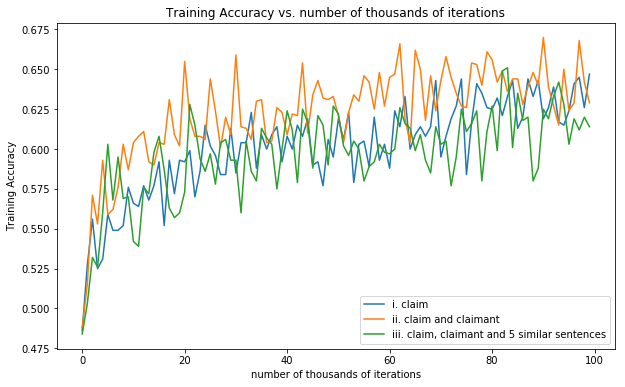

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(all_train_accuracies_i, label='i. claim')
plt.plot(all_train_accuracies_ii, label='ii. claim and claimant')
plt.plot(all_train_accuracies_iii, label='iii. claim, claimant and 5 similar sentences')

plt.xlabel('number of thousands of iterations')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. number of thousands of iterations')
plt.legend(loc='lower right')
plt.show()

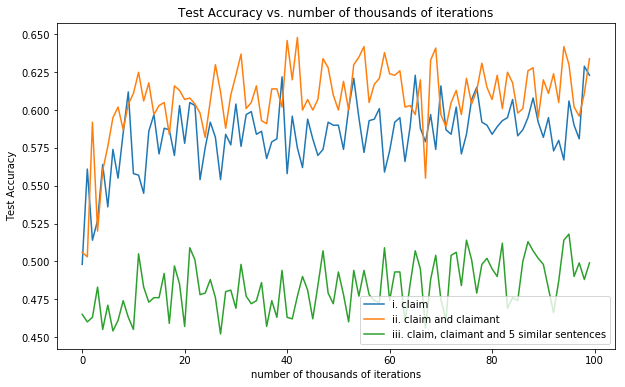

In [0]:
plt.figure(figsize=(10,6))
plt.plot(all_test_accuracies_i, label='i. claim')
plt.plot(all_test_accuracies_ii, label='ii. claim and claimant')
plt.plot(all_test_accuracies_iii, label='iii. claim, claimant and 5 similar sentences')

plt.xlabel('number of thousands of iterations')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. number of thousands of iterations')
plt.legend(loc='lower right')
plt.show()